In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score,roc_curve
from sklearn.metrics import precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score,f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from matplotlib.colors import LinearSegmentedColormap


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
df_feature = pd.read_csv('...\features_data.csv')
df_equity = pd.read_csv('...\equity_value_data.csv')

# Identify Churned users 

In [4]:
# sort the data by user_id and timestamp
df_equity.sort_values(['user_id','timestamp'],inplace = True)
df_equity.reset_index(drop = True, inplace = True)

# get the user list
User_list = df_equity['user_id'].unique()

# add the column 'Last_date' as the previous date 
df_equity['close_date'] = pd.to_datetime(df_equity['timestamp']).dt.date
df_equity['close_date'] = df_equity['close_date'].values.astype('datetime64[D]')
df_equity['Last_date'] = df_equity.groupby('user_id')['close_date'].shift(1)
df_equity.head()

,timestamp,close_equity,user_id,close_date,Last_date
0,2016-08-18T00:00:00Z,1211.6055,0012db34aa7b083f5714e7831195e54d,2016-08-18,NaT
1,2016-08-19T00:00:00Z,1173.5640,0012db34aa7b083f5714e7831195e54d,2016-08-19,2016-08-18
2,2016-08-22T00:00:00Z,1253.0597,0012db34aa7b083f5714e7831195e54d,2016-08-22,2016-08-19
3,2016-08-23T00:00:00Z,1252.9050,0012db34aa7b083f5714e7831195e54d,2016-08-23,2016-08-22
4,2016-08-24T00:00:00Z,1262.1360,0012db34aa7b083f5714e7831195e54d,2016-08-24,2016-08-23


In [5]:
# get the last date in the data set
end = df_equity['close_date'].max()
#print(start,end)

In [6]:
##loop all the users to identify the churn users

churn_bit = []

for i in range(len(User_list)):
    
    df_temp = df_equity[df_equity['user_id'] == User_list[i]].reset_index(drop = True)
    df_temp['Last_date'] = np.where(df_temp['Last_date'].notnull(),df_temp['Last_date'],df_temp['close_date'])
    
    # fill the date if the last date is not 2017/08/17
    if df_temp['close_date'].iloc[-1] != end:
        df_temp = df_temp.append(df_temp.iloc[-1]).reset_index(drop = True)
        df_temp.loc[len(df_temp)-1,'Last_date'] = df_temp['close_date'].iloc[-1]
        df_temp.loc[len(df_temp)-1,'close_date'] = end
     
    # count the calendar days where the close_equity falls below $10

    df_temp['calendar_days'] = (df_temp['close_date'] - df_temp['Last_date']).dt.days
    calendar_days_max = df_temp['calendar_days'].max()
    
    # if the maximun consecutive calendar days where close_equity<=10 is longer than 28, then labeled the user as churned
    if calendar_days_max >= 28:
        churn_bit.append(1)
    else:
        churn_bit.append(0) 
        


In [7]:
df_churn = pd.DataFrame({'user_id' :User_list,'churn_bit' : churn_bit},columns = {'user_id','churn_bit'})
churn_pct = df_churn['churn_bit'].sum()/len(df_churn['user_id'])
print(f'There are {churn_pct*100:3.1f} % users have churned in the data provided')

There are 18.0 % users have churned in the data provided


# Model for churn users prediction

In [8]:
#combine the churn bit we got from question (a)
df_feature = pd.merge(df_feature,df_churn,on=['user_id'])
df_feature.head()

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn_bit
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0


## Basic data exploration

### From the last question, where the churned users are around 18% of the sample, the dataset is mildly imbalanced. Here we try to build model without oversampling/downsampling

In [9]:
## check null values in the dataset
df_feature.isna().sum()

risk_tolerance                  0
investment_experience           0
liquidity_needs                 0
platform                        0
time_spent                      0
instrument_type_first_traded    0
first_deposit_amount            0
time_horizon                    0
user_id                         0
churn_bit                       0
dtype: int64

In [10]:
## check the catogorical features
col_cat = ['risk_tolerance', 'investment_experience', 'liquidity_needs','platform','instrument_type_first_traded','time_horizon']
df_feature[col_cat].apply(pd.Series.value_counts)

,risk_tolerance,investment_experience,liquidity_needs,platform,instrument_type_first_traded,time_horizon
0,NaN,NaN,NaN,NaN,13.0,NaN
Android,NaN,NaN,NaN,1529.0,NaN,NaN
adr,NaN,NaN,NaN,NaN,197.0,NaN
both,NaN,NaN,NaN,505.0,NaN,NaN
cef,NaN,NaN,NaN,NaN,20.0,NaN
etp,NaN,NaN,NaN,NaN,383.0,NaN
extensive_investment_exp,NaN,76.0,NaN,NaN,NaN,NaN
good_investment_exp,NaN,1134.0,NaN,NaN,NaN,NaN
high_risk_tolerance,3566.0,NaN,NaN,NaN,NaN,NaN
iOS,NaN,NaN,NaN,3550.0,NaN,NaN


In [11]:
## check the numerical features
df_feature[['time_spent','first_deposit_amount']].describe()

,time_spent,first_deposit_amount
count,5584.000000,5584.000000
mean,34.509706,633.566805
std,155.080551,2118.323263
min,0.000000,0.000000
25%,2.848908,50.000000
50%,13.474708,100.000000
75%,33.823829,500.000000
max,8788.329450,50000.000000


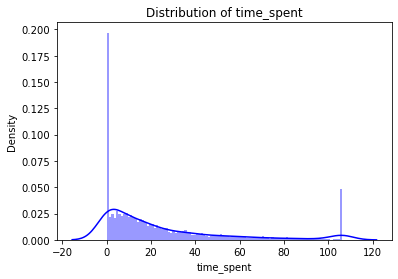

In [12]:
## Look at the distribution of the numerical features
df_model_temp = df_feature
df_model_temp.loc[df_model_temp['time_spent'] >=df_model_temp['time_spent'].quantile(0.95),'time_spent'] = df_model_temp['time_spent'].quantile(0.95)

x = df_model_temp['time_spent']
ax = sns.distplot(x, bins=100, color='blue')
ax.set_title("Distribution of time_spent")
plt.show()

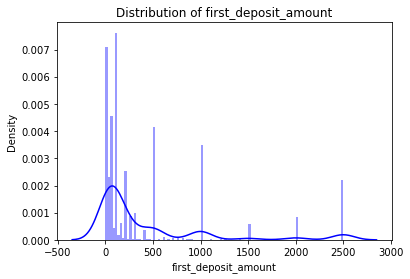

In [13]:
df_model_temp.loc[df_model_temp['first_deposit_amount'] >=df_model_temp['first_deposit_amount'].quantile(0.95),'first_deposit_amount'] = df_model_temp['first_deposit_amount'].quantile(0.95)
x = df_model_temp['first_deposit_amount']
ax = sns.distplot(x, bins=100, color='blue')
ax.set_title("Distribution of first_deposit_amount")
plt.show()

## Feature Engineering

In [14]:
## add dummy variables for categorical variables
enc_df = pd.get_dummies(df_feature[col_cat], prefix=col_cat)
df_model = enc_df.merge(df_feature[['time_spent','first_deposit_amount','user_id', 'churn_bit']], left_index=True, right_index=True)
df_model.head()

,risk_tolerance_high_risk_tolerance,risk_tolerance_low_risk_tolerance,risk_tolerance_med_risk_tolerance,investment_experience_extensive_investment_exp,investment_experience_good_investment_exp,investment_experience_limited_investment_exp,investment_experience_no_investment_exp,liquidity_needs_not_important_liq_need,liquidity_needs_somewhat_important_liq_need,liquidity_needs_very_important_liq_need,...,instrument_type_first_traded_stock,instrument_type_first_traded_tracking,instrument_type_first_traded_wrt,time_horizon_long_time_horizon,time_horizon_med_time_horizon,time_horizon_short_time_horizon,time_spent,first_deposit_amount,user_id,churn_bit
0,1,0,0,0,0,1,0,0,0,1,...,1,0,0,0,1,0,33.129417,40.0,895044c23edc821881e87da749c01034,0
1,0,0,1,0,0,1,0,0,0,1,...,1,0,0,0,0,1,16.573517,200.0,458b1d95441ced242949deefe8e4b638,0
2,0,0,1,0,0,1,0,0,0,1,...,1,0,0,1,0,0,10.008367,25.0,c7936f653d293479e034865db9bb932f,0
3,0,0,1,0,0,1,0,0,0,1,...,1,0,0,0,0,1,1.031633,100.0,b255d4bd6c9ba194d3a350b3e76c6393,0
4,1,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,8.187250,20.0,4a168225e89375b8de605cbc0977ae91,0


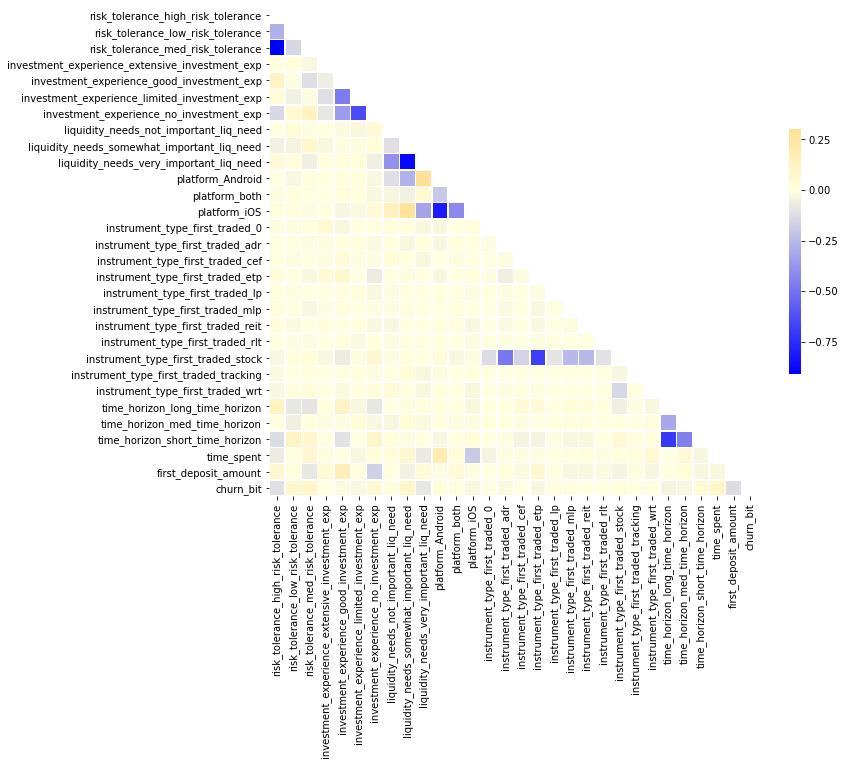

In [15]:
## check the variables correlation
col_list_all = df_model.columns.values.tolist()
corr = df_model[col_list_all].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = LinearSegmentedColormap.from_list('', [ 'blue','lightyellow','orange'])
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [16]:
# remove the dummy vairables that have the least corr with target label of each feature
corr.reset_index(inplace = True)
corr['churn_bit_abs'] = abs(corr['churn_bit'])
corr['feature']=corr['index'].apply(lambda x: x.split('_')[0] if (x != 'first_deposit_amount') & (x != 'time_spent') else x)
corr.sort_values(by = 'churn_bit_abs', ascending = False, inplace = True)
corr = corr.groupby('feature').apply(lambda x: x.iloc[:-1] if len(x)>1 else x).reset_index(drop=True)
corr.sort_values(by = 'feature', inplace = True)
corr[['index','churn_bit']]

,index,churn_bit
0,churn_bit,1.000000
1,first_deposit_amount,-0.122320
10,instrument_type_first_traded_cef,-0.004731
9,instrument_type_first_traded_mlp,0.005101
8,instrument_type_first_traded_tracking,-0.006278
7,instrument_type_first_traded_0,-0.012993
11,instrument_type_first_traded_rlt,0.004377
5,instrument_type_first_traded_adr,-0.019003
4,instrument_type_first_traded_lp,0.019178
3,instrument_type_first_traded_stock,0.031996


In [17]:
#Standardize all the numerical feature
scaler = StandardScaler()
for Col in ['first_deposit_amount','time_spent']:
    #name = Col + '_std'
    df_model[Col] = scaler.fit_transform(df_model[Col].values.reshape(-1, 1))

df_model.head()

,risk_tolerance_high_risk_tolerance,risk_tolerance_low_risk_tolerance,risk_tolerance_med_risk_tolerance,investment_experience_extensive_investment_exp,investment_experience_good_investment_exp,investment_experience_limited_investment_exp,investment_experience_no_investment_exp,liquidity_needs_not_important_liq_need,liquidity_needs_somewhat_important_liq_need,liquidity_needs_very_important_liq_need,...,instrument_type_first_traded_stock,instrument_type_first_traded_tracking,instrument_type_first_traded_wrt,time_horizon_long_time_horizon,time_horizon_med_time_horizon,time_horizon_short_time_horizon,time_spent,first_deposit_amount,user_id,churn_bit
0,1,0,0,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0.308806,-0.588710,895044c23edc821881e87da749c01034,0
1,0,0,1,0,0,1,0,0,0,1,...,1,0,0,0,0,1,-0.262581,-0.344322,458b1d95441ced242949deefe8e4b638,0
2,0,0,1,0,0,1,0,0,0,1,...,1,0,0,1,0,0,-0.489161,-0.611621,c7936f653d293479e034865db9bb932f,0
3,0,0,1,0,0,1,0,0,0,1,...,1,0,0,0,0,1,-0.798970,-0.497065,b255d4bd6c9ba194d3a350b3e76c6393,0
4,1,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,-0.552012,-0.619259,4a168225e89375b8de605cbc0977ae91,0


## Feature Selection 

### Use recursive feature elimination with cv to perform basic feature selection. Since the data is mildly imbalance between positive and negative classes, and the goal is to detect churned users. so we use recall as the scoring metric 

In [18]:
#all the features
col_list_all_lr = corr['index'].values.tolist()
X = df_model[col_list_all_lr[1:]]
y = df_model[col_list_all_lr[0]]


clf =  LogisticRegression(solver='lbfgs')

rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5),
              scoring='recall')
             #min_features_to_select=10)
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LogisticRegression(), scoring='recall')

In [19]:
#print out our final feature list
col_list_selected = [i for (i, v) in zip(col_list_all_lr[1:], rfecv.get_support()) if v]
print(len(col_list_selected))
col_list_selected

15


['first_deposit_amount',
 'instrument_type_first_traded_mlp',
 'instrument_type_first_traded_tracking',
 'instrument_type_first_traded_0',
 'instrument_type_first_traded_rlt',
 'instrument_type_first_traded_lp',
 'instrument_type_first_traded_stock',
 'instrument_type_first_traded_wrt',
 'liquidity_needs_very_important_liq_need',
 'liquidity_needs_somewhat_important_liq_need',
 'platform_Android',
 'risk_tolerance_high_risk_tolerance',
 'risk_tolerance_med_risk_tolerance',
 'time_horizon_short_time_horizon',
 'time_spent']

## a. Logistic Regression

In [29]:
#import sklearn.external.joblib as extjoblib
import joblib

In [30]:
## split the data set into 80% train and 20% test

joblib.dump(df_model, r'D:\sth\interview\Robinhood\df_model.pkl')

X = df_model[col_list_selected]
y = df_model['churn_bit']

X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.2, random_state=0)

In [21]:
lr = LogisticRegression(solver='lbfgs').fit(X_train, y_train)

In [23]:
lr.intercept_

array([-1.09744278])

Training Model metrics
	 Accuracy: 81.84 %,  Precision: 75.00 %,  Recall: 0.74 %,  F1: 1.46 %
Testing Model metrics
	 Accuracy: 82.81 %,  Precision: 0.00 %,  Recall: 0.00 %,  F1: 0.00 %


Text(0.5, 1, 'Testing Confusion Matrix')

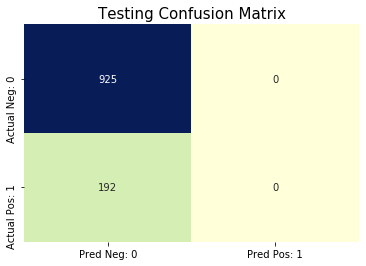

In [22]:
#calculate the model perf metrics
y_train_hat = lr.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_hat)*100
train_precision = precision_score(y_train, y_train_hat)*100
train_recall = recall_score(y_train, y_train_hat)*100
train_f1 = f1_score(y_train, y_train_hat)*100
y_test_hat = lr.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_hat)*100
test_precision = precision_score(y_test, y_test_hat)*100
test_recall = recall_score(y_test, y_test_hat)*100
test_f1 = f1_score(y_test, y_test_hat)*100

print('Training Model metrics\n\t Accuracy: %.2f %%,  Precision: %.2f %%,  Recall: %.2f %%,  F1: %.2f %%' % (train_accuracy,train_precision,train_recall,train_f1))
print('Testing Model metrics\n\t Accuracy: %.2f %%,  Precision: %.2f %%,  Recall: %.2f %%,  F1: %.2f %%' % (test_accuracy,test_precision,test_recall,test_f1))

#print the confusion matrix
cm_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_test_hat), columns=['Pred Neg: 0', 'Pred Pos: 1'], 
                                 index=[ 'Actual Neg: 0','Actual Pos: 1'])

ax = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu',cbar = False)
plt.title('Testing Confusion Matrix', fontsize = 15)

### Logistic regression yields an accuracy around 82% on train dataset, and around 83% on test dataset. However this classifier can't identify any churned user on test data, it has really low recall.

## b. Random Forest Classifier

In [23]:
##Now lets try random forest
rf = RandomForestClassifier(criterion = 'gini',
                            max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)

## use grid search for hyperparams tunning 
## this section is commented out for downloading purpose

# param_grid = {'max_depth' : [3,5,8,10],
#               'min_samples_leaf' : [1,3,5, 10], 
#               'min_samples_split' : [2, 5, 10, 15],
#               'n_estimators': [300, 500, 1000,1200]}

# gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='recall', cv=3, n_jobs=-1)
# gs = gs.fit(X_train, y_train)
# rf = gs.best_estimator_

In [1091]:
#print(gs.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [24]:
rf = RandomForestClassifier(criterion = 'gini',
                            max_features='auto',
                            max_depth=10,
                            min_samples_leaf=1, 
                            min_samples_split=2,
                            n_estimators=500,
                            oob_score=True,
                            random_state=1,
                            n_jobs=-1)
rf = rf.fit(X_train, y_train)

Training Model metrics
	 Accuracy: 84.49 %,  Precision: 100.00 %,  Recall: 14.97 %,  F1: 26.04 %
Testing Model metrics
	 Accuracy: 82.45 %,  Precision: 33.33 %,  Recall: 2.08 %,  F1: 3.92 %


Text(0.5, 1, 'Testing Confusion Matrix')

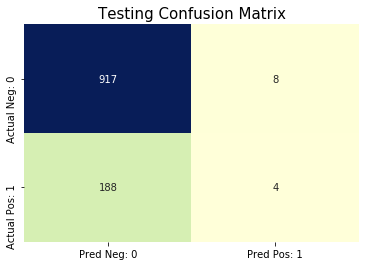

In [25]:
#calculate the model perf metrics
y_train_hat = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_hat)*100
train_precision = precision_score(y_train, y_train_hat)*100
train_recall = recall_score(y_train, y_train_hat)*100
train_f1 = f1_score(y_train, y_train_hat)*100
y_test_hat = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_hat)*100
test_precision = precision_score(y_test, y_test_hat)*100
test_recall = recall_score(y_test, y_test_hat)*100
test_f1 = f1_score(y_test, y_test_hat)*100

print('Training Model metrics\n\t Accuracy: %.2f %%,  Precision: %.2f %%,  Recall: %.2f %%,  F1: %.2f %%' % (train_accuracy,train_precision,train_recall,train_f1))
print('Testing Model metrics\n\t Accuracy: %.2f %%,  Precision: %.2f %%,  Recall: %.2f %%,  F1: %.2f %%' % (test_accuracy,test_precision,test_recall,test_f1))

#print the confusion matrix
cm_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_test_hat), columns=['Pred Neg: 0', 'Pred Pos: 1'], 
                                 index=[ 'Actual Neg: 0','Actual Pos: 1'])

ax = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu',cbar = False)
plt.title('Testing Confusion Matrix', fontsize = 15)

### Compared to Logistic Regression, Random Forest model has the similar accuracy yet a higher recall, but still needs improvement. 

## c. XGBoost

In [26]:
## Now let's try XGBoost model. 

## use grid search for hyperparams tunning 
## we need to have constraints to avoid overfitting

## this section is commented out for downloading purpose

# xgb = XGBClassifier(n_estimators=300, objective='binary:logistic',silent=True, nthread=1, n_jobs=-1)
# param_grid_xgb = {
#         'min_child_weight': [1, 5, 10],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.5, 0.7],
#         'max_depth': [3,5],
#         'learning_rate' : [0.01,0.05,0.1]
#         }

# gs_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, scoring='recall', cv=3, n_jobs=-1)
# gs_xgb = gs_xgb.fit(X_train, y_train)
# xgb = gs_xgb.best_estimator_

In [1094]:
#print(gs_xgb.best_params_)

{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.7}


In [27]:
xgb = XGBClassifier(n_estimators=300, 
                    colsample_bytree=0.7,
                    subsample=0.7,
                    max_depth=5,
                    learning_rate=0.1,
                    min_child_weight=1,
                    objective='binary:logistic',
                    silent=True, 
                    nthread=1, 
                    n_jobs=-1)

xgb.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.7, max_depth=5, n_estimators=300, n_jobs=-1,
              nthread=1, silent=True, subsample=0.7)

Training Model metrics
	 Accuracy: 86.97 %,  Precision: 93.63 %,  Recall: 30.67 %,  F1: 46.21 %
Testing Model metrics
	 Accuracy: 81.83 %,  Precision: 40.68 %,  Recall: 12.50 %,  F1: 19.12 %


Text(0.5, 1, 'Testing Confusion Matrix')

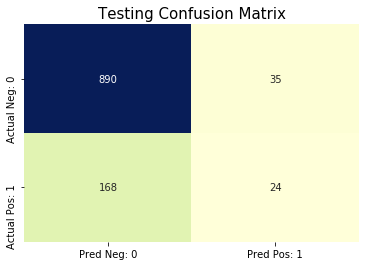

In [28]:
#calculate the model perf metrics
y_train_hat = xgb.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_hat)*100
train_precision = precision_score(y_train, y_train_hat)*100
train_recall = recall_score(y_train, y_train_hat)*100
train_f1 = f1_score(y_train, y_train_hat)*100
y_test_hat = xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_hat)*100
test_precision = precision_score(y_test, y_test_hat)*100
test_recall = recall_score(y_test, y_test_hat)*100
test_f1 = f1_score(y_test, y_test_hat)*100

print('Training Model metrics\n\t Accuracy: %.2f %%,  Precision: %.2f %%,  Recall: %.2f %%,  F1: %.2f %%' % (train_accuracy,train_precision,train_recall,train_f1))
print('Testing Model metrics\n\t Accuracy: %.2f %%,  Precision: %.2f %%,  Recall: %.2f %%,  F1: %.2f %%' % (test_accuracy,test_precision,test_recall,test_f1))

#print the confusion matrix
cm_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_test_hat), columns=['Pred Neg: 0', 'Pred Pos: 1'], 
                                 index=[ 'Actual Neg: 0','Actual Pos: 1'])

ax = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu',cbar = False)
plt.title('Testing Confusion Matrix', fontsize = 15)

### The boosting model has the highest recall and accuracy on training data, and all the model performance metrics are better than the other two models. However the recall score is still too low, that the model couldn't successfully identify the churned user. With limited given features, we should try to balance the data and retrain the model to achieve better classification power

## Balance dataset

In [29]:
smote = SMOTE(sampling_strategy='minority',random_state=1)
X_sm, y_sm = smote.fit_resample(X, y)

# check the traget variable 
churn_pct_sm = sum(y_sm)/len(y_sm)
print(f'Now the dataset has {churn_pct_sm*100:3.1f} % churned users')

Now the dataset has 50.0 % churned users


In [30]:
## split the data set into 80% train and 20% test
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm.values.ravel(), test_size=0.2, random_state=0)

In [31]:
## use grid search for hyperparams tunning 
## we need to have constraints to avoid overfitting

## this section is commented out for downloading purpose

# xgb_sm = XGBClassifier(n_estimators=300, objective='binary:logistic',silent=True, nthread=1, n_jobs=-1)
# param_grid_xgb = {
#      'min_child_weight': [1, 5, 10],
#      'subsample': [0.5, 0.7],
#      'colsample_bytree': [0.5, 0.7],
#      'max_depth': [3,5],
#      'learning_rate' : [0.01,0.05,0.1]
#      }

# gs_xgb_sm = GridSearchCV(estimator=xgb_sm, param_grid=param_grid_xgb, scoring='recall', cv=3, n_jobs=-1)
# gs_xgb_sm = gs_xgb_sm.fit(X_train, y_train)
# xgb_sm = gs_xgb_sm.best_estimator_

In [69]:
#print(gs_xgb_sm.best_params_)

{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5}


In [32]:
xgb_sm = XGBClassifier(n_estimators=300, 
                    colsample_bytree=0.7,
                    subsample=0.5,
                    max_depth=5,
                    learning_rate=0.1,
                    min_child_weight=1,
                    objective='binary:logistic',
                    silent=True, 
                    nthread=1, 
                    n_jobs=-1)

xgb_sm.fit(X_train_sm, y_train_sm)

XGBClassifier(colsample_bytree=0.7, max_depth=5, n_estimators=300, n_jobs=-1,
              nthread=1, silent=True, subsample=0.5)

Training Model metrics
	 Accuracy: 86.02 %,  Precision: 90.77 %,  Recall: 80.30 %,  F1: 85.22 %
Testing Model metrics
	 Accuracy: 78.65 %,  Precision: 81.43 %,  Recall: 73.39 %,  F1: 77.20 %


Text(0.5, 1, 'Testing Confusion Matrix on Balanced Dataset')

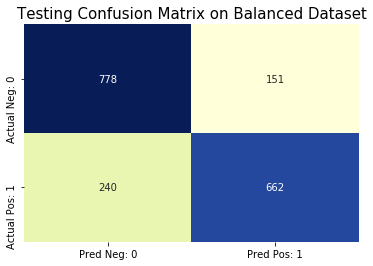

In [33]:
#calculate the model perf metrics based on balanced data
y_train_hat = xgb_sm.predict(X_train_sm)
train_accuracy = accuracy_score(y_train_sm, y_train_hat)*100
train_precision = precision_score(y_train_sm, y_train_hat)*100
train_recall = recall_score(y_train_sm, y_train_hat)*100
train_f1 = f1_score(y_train_sm, y_train_hat)*100
y_test_hat = xgb_sm.predict(X_test_sm)
test_accuracy = accuracy_score(y_test_sm, y_test_hat)*100
test_precision = precision_score(y_test_sm, y_test_hat)*100
test_recall = recall_score(y_test_sm, y_test_hat)*100
test_f1 = f1_score(y_test_sm, y_test_hat)*100

print('Training Model metrics\n\t Accuracy: %.2f %%,  Precision: %.2f %%,  Recall: %.2f %%,  F1: %.2f %%' % (train_accuracy,train_precision,train_recall,train_f1))
print('Testing Model metrics\n\t Accuracy: %.2f %%,  Precision: %.2f %%,  Recall: %.2f %%,  F1: %.2f %%' % (test_accuracy,test_precision,test_recall,test_f1))

#print the confusion matrix
cm_matrix = pd.DataFrame(data=confusion_matrix(y_test_sm, y_test_hat), columns=['Pred Neg: 0', 'Pred Pos: 1'], 
                                 index=[ 'Actual Neg: 0','Actual Pos: 1'])

ax = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu',cbar = False)
plt.title('Testing Confusion Matrix on Balanced Dataset', fontsize = 15)

Testing Model metrics on Imalanced Dataset
	 Accuracy: 82.18 %,  Precision: 47.93 %,  Recall: 42.19 %,  F1: 44.88 %


Text(0.5, 1, 'Testing Confusion Matrix on Imalanced Dataset')

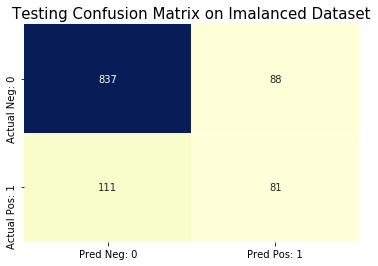

In [34]:
#Now calculate the model perf metrics on imbalanced testing data for comparison
y_test_hat = xgb_sm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_hat)*100
test_precision = precision_score(y_test, y_test_hat)*100
test_recall = recall_score(y_test, y_test_hat)*100
test_f1 = f1_score(y_test, y_test_hat)*100

print('Testing Model metrics on Imalanced Dataset\n\t Accuracy: %.2f %%,  Precision: %.2f %%,  Recall: %.2f %%,  F1: %.2f %%' % (test_accuracy,test_precision,test_recall,test_f1))

#print the confusion matrix
cm_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_test_hat), columns=['Pred Neg: 0', 'Pred Pos: 1'], 
                                 index=[ 'Actual Neg: 0','Actual Pos: 1'])

ax = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu',cbar = False)
plt.title('Testing Confusion Matrix on Imalanced Dataset', fontsize = 15)

### With the balanced data, XGBoost model yields a higher recall score than all the previously trained models. We compared the model metrics on imbalanced dataset, this new model has a significantly higher recall. The accuracy on balanced testing data is lower than on balanced training data by around 8%, suggesting that the model is slightly overfitting. But in general, this XGBoost model has a higher classification power.

## Feature importance

### From the correlation heat map in Feature engineering section and Feature selection section, feature 'first_deposit_amount' has the highest correlation with our target variable. However for catagorical features, the importance could be reduced by splitting into dummy variables. We can use the feature_importances from XGBoost to get the aggregated importance of catagorical variables.

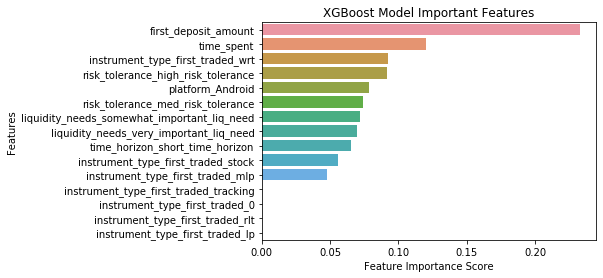

In [35]:
feature_scores = pd.DataFrame({'feature' : X_train_sm.columns,
                               'feature_importance':xgb_sm.feature_importances_}).sort_values(by = 'feature_importance',ascending=False)

sns.barplot(x=feature_scores['feature_importance'], y=feature_scores['feature'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("XGBoost Model Important Features")
plt.show()

### The output feature_importances_ is counting the numbers of time that each feature splitted on in the model, then averaged across all the trees. The higher the number is, the more important and  informative the feature is to classify the user. We can sum up the feature_importances of dummies that belong to the same categorical feature and then compare.

In [36]:
feature_scores['feature_grp'] = feature_scores['feature'].apply(lambda x: x.split('_')[0] if (x != 'first_deposit_amount') & (x != 'time_spent')
                                                                else x)
feature_scores.groupby('feature_grp')['feature_importance'].sum().reset_index(name ='importance_ttl').sort_values(by = 'importance_ttl',ascending = False)

,feature_grp,importance_ttl
0,first_deposit_amount,0.233092
1,instrument,0.195930
4,risk,0.166128
2,liquidity,0.141080
6,time_spent,0.119962
3,platform,0.078794
5,time,0.065014


### We noticed that numerical feature 'first_deposit_amount' ,and then categorical features 'instrument_type_first_traded' and 'risk_tolerance' are the top 3 important features in our classification model. This suggests that these features are the most important ones that correlate to user churn